In [1]:
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm

In [2]:
pattern = os.path.join('/home/tbellagio/scratch/slim_grenenet/results', '**', 'allele_freq.csv')

In [3]:
allele_freq_files = glob.glob(pattern, recursive=True)

In [4]:
allele_freq_founder_file = '/home/tbellagio/scratch/slim_grenenet/data/allele_freq_founder_offset.csv'
allele_freq_founder = pd.read_csv(allele_freq_founder_file)

In [5]:
def calc_delta_p(allele_freq,allele_freq_founder ): 
    allele_freq_founder['chrom_pos'] = allele_freq_founder['chrom_pos'].astype(int)
    ## eliminate duplciates basically positions where the allele freq is the same in all 
    allele_freq = allele_freq.round(6)

    allele_freq = allele_freq.set_index('chrom_pos')   #.drop_duplicates()
    allele_freq = allele_freq.reset_index()
    allele_freq = allele_freq.fillna(0)

    ## first calculate delta p norm 
    ## imoport allele freq of the founder and normalize 
    allele_freq = pd.merge(allele_freq,allele_freq_founder, on ='chrom_pos')
    allele_freq = allele_freq.set_index('chrom_pos')
    
    delta_p = pd.DataFrame() #index = allele_freq.index

    for col in allele_freq.columns:
        delta_p[col] = allele_freq[col] - allele_freq['allele_freq_founder']
        
    delta_p = delta_p.drop(['allele_freq_founder','deno_norm'],axis=1)

    #delta_p = delta_p.round(6)
    ## eliminate rows with all the same values
    #delta_p = delta_p[delta_p.std(axis=1) > 0]
    return delta_p

In [6]:
def calc_delta_p_norm(allele_freq,allele_freq_founder ): 
    allele_freq_founder['chrom_pos'] = allele_freq_founder['chrom_pos'].astype(int)
    ## eliminate duplciates basically positions where the allele freq is the same in all 
    allele_freq = allele_freq.round(6)

    allele_freq = allele_freq.set_index('chrom_pos')   #.drop_duplicates()
    allele_freq = allele_freq.reset_index()
    allele_freq = allele_freq.fillna(0)

    ## first calculate delta p norm 
    ## imoport allele freq of the founder and normalize 
    allele_freq = pd.merge(allele_freq,allele_freq_founder, on ='chrom_pos')
    allele_freq = allele_freq.set_index('chrom_pos')
    
    delta_p_norm = pd.DataFrame() #index = allele_freq.index

    for col in allele_freq.columns:
        delta_p_norm[col] = (allele_freq[col] - allele_freq['allele_freq_founder']) / allele_freq['deno_norm']
        
    delta_p_norm = delta_p_norm.drop(['allele_freq_founder','deno_norm'],axis=1)

    #delta_p_norm = delta_p_norm.round(6)
    ## eliminate rows with all the same values
    #delta_p_norm = delta_p_norm[delta_p_norm.std(axis=1) > 0]
    return delta_p_norm

In [7]:
def calc_rsquared_values(df, name):
    p_values = []
    rsquared_values = []
    slopes = []
    for i in range(len(df)):
        y = np.array(df.iloc[i,1:]).astype(float)
        mod = sm.OLS(y, X)
        res = mod.fit()
        rsquared_values.append(res.rsquared)
        p_values.append(res.pvalues[0])
        slopes.append(res.params[0])
    rsquared_values = pd.DataFrame({'chrom_pos': df['chrom_pos'],'rsquared_values' : rsquared_values, 'p_values': p_values, 'slopes': slopes,'model': name})
    return rsquared_values

In [8]:
right_order_cols = ['chrom_pos', 'optima-2_subp1', 'optima-2_subp2', 'optima-2_subp3',
       'optima-2_subp4', 'optima-2_subp5', 'optima-1_subp1', 'optima-1_subp2',
       'optima-1_subp3', 'optima-1_subp4', 'optima-1_subp5', 'optima0_subp1',
       'optima0_subp2', 'optima0_subp3', 'optima0_subp4', 'optima0_subp5',
       'optima1_subp1', 'optima1_subp2', 'optima1_subp3', 'optima1_subp4',
       'optima1_subp5', 'optima2_subp1', 'optima2_subp2', 'optima2_subp3',
       'optima2_subp4', 'optima2_subp5']

In [10]:
def create_df_r2 (path_allele_freq, heritability, freq, pi, rep, right_order_cols):

    causal_loci_file = path_allele_freq.split('arq')[0] + 'arq' + path_allele_freq.split('arq')[1].split('/')[0] + '/loci_effectsize.csv'
    causal_loci = pd.read_csv(causal_loci_file, index_col = [0])
    allele_freq = pd.read_csv(path_allele_freq)
    allele_freq = allele_freq[allele_freq['chrom_pos'].isin(causal_loci.pos)]
    allele_freq = allele_freq.drop('Unnamed: 0',axis=1)
    
    allele_freq = allele_freq.fillna(0)
    allele_freq = allele_freq.set_index('chrom_pos').drop_duplicates().reset_index()

    
    delta_p = calc_delta_p(allele_freq,allele_freq_founder )
    delta_p_norm = calc_delta_p_norm(allele_freq,allele_freq_founder )
    delta_p = delta_p.reset_index()
    delta_p_norm = delta_p_norm.reset_index()
    allele_freq = allele_freq[right_order_cols]
    delta_p = delta_p[right_order_cols]
    delta_p_norm = delta_p_norm[right_order_cols]
    
    allele_freq_r2 = calc_rsquared_values(allele_freq, 'allele_freq')
    delta_p_r2 = calc_rsquared_values(delta_p,'delta_p' )
    delta_p_norm_r2 = calc_rsquared_values(delta_p_norm, 'delta_p_norm')
    
    all_transformations = pd.concat([allele_freq_r2, delta_p_r2, delta_p_norm_r2],axis=0)
    all_transformations = all_transformations.merge(causal_loci, left_on ='chrom_pos', right_on= 'pos', how= 'left').drop('pos',axis=1)
    #all_transformations = pd.merge(allele_freq_r2,delta_p_r2, on = 'chrom_pos').merge(delta_p_norm_r2,  on = 'chrom_pos')

    #all_transformations = all_transformations.merge(causal_loci, left_on ='chrom_pos', right_on= 'pos').drop('pos',axis=1)
    #all_transformations['sc_abs'] = all_transformations['sc'].abs()
    #all_transformations = all_transformations.sort_values(by = 'sc_abs')
    #all_transformations = all_transformations.drop(['chrom_pos', 'sc_abs'],axis=1) #.set_index('sc')
    #all_transformations['sc'] = all_transformations['sc'].round(4)
    #all_transformations = all_transformations.set_index('sc')
    #all_transformations_melt = all_transformations.reset_index().melt(id_vars=['sc'])
    
    all_transformations['heritability'] = heritability
    all_transformations['freq'] = freq
    all_transformations['pi'] = pi
    all_transformations['rep'] = rep
    return all_transformations

In [22]:
allele_freq_files = [i for i in allele_freq_files if '/strongsel' in i]

In [182]:
path_allele_freq  = allele_freq_files[0]

In [183]:
path_allele_freq

'/home/tbellagio/scratch/slim_grenenet/results/arq_highfreq_onehpoly_4/mediumh/strongsel/allele_freq.csv'

In [192]:
causal_loci_file = path_allele_freq.split('arq')[0] + 'arq' + path_allele_freq.split('arq')[1].split('/')[0] + '/loci_effectsize.csv'
causal_loci = pd.read_csv(causal_loci_file, index_col = [0])
allele_freq = pd.read_csv(path_allele_freq)
#allele_freq = allele_freq[allele_freq['chrom_pos'].isin(causal_loci.pos)]
allele_freq = allele_freq.drop('Unnamed: 0',axis=1)

In [ ]:
allele_freq

In [187]:
allele_freq_norm = pd.read_csv('/home/tbellagio/scratch/slim_grenenet/results/arq_highfreq_onehpoly_4/mediumh/strongsel/allele_freq_norm.csv')

In [195]:
allele_freq_norm

,chrom_pos,optima-2_subp1,optima-2_subp2,optima-2_subp3,optima-2_subp4,optima-2_subp5,optima-1_subp1,optima-1_subp2,optima-1_subp3,optima-1_subp4,...,optima1_subp1,optima1_subp2,optima1_subp3,optima1_subp4,optima1_subp5,optima2_subp1,optima2_subp2,optima2_subp3,optima2_subp4,optima2_subp5
0,291,0.811521,-0.212238,-0.786895,-0.045636,1.096435,-0.052879,0.120967,0.041287,-0.093926,...,0.323787,0.041287,-0.306404,-0.185678,-0.064952,1.707310,1.403079,0.207890,0.459000,1.572096
1,346,1.349012,1.764950,0.970383,1.319771,1.364642,0.669900,0.563017,0.717292,0.546379,...,-0.173571,-0.391875,-0.181638,-0.220963,-0.310704,-0.910663,-1.119387,-0.997379,-0.895537,-0.953517
2,349,-1.008734,-1.008734,-1.008734,-1.008734,-1.008734,-1.008734,-0.554350,-1.008734,-1.008734,...,-0.496095,-0.880574,-0.228125,0.738897,0.226259,-0.670858,-1.008734,-1.008734,-1.008734,-1.008734
3,352,-1.022124,-1.022124,-0.771847,-1.022124,-0.129626,0.262318,0.422873,0.526762,0.054541,...,0.238707,0.602317,-0.365736,-0.181570,0.342595,-1.022124,-1.022124,-0.885180,-0.710458,-1.022124
4,353,-0.363973,-0.840189,-0.784346,-0.860354,-0.723849,-0.005647,-0.160767,0.244094,0.278221,...,-0.591998,-0.453942,-0.453942,-0.342256,-0.652494,-1.074419,-0.965835,-1.074419,-0.947221,-0.930158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584027,119145929,-1.017621,-1.017621,-1.017621,-1.017621,-1.017621,-0.688522,-0.136107,-0.659139,-0.236012,...,-0.171367,1.333084,1.074506,1.003985,0.939341,-0.500466,-1.017621,-1.017621,-1.017621,-0.835442
1584028,119145967,-1.064516,-0.609595,-0.124815,-0.822126,-0.899410,-0.693905,-0.507721,-0.732547,-0.439219,...,0.359966,0.417929,1.023905,0.760437,0.769219,0.374018,-0.173995,-0.077390,0.576010,0.321324
1584029,119145990,-1.017621,-1.017621,-1.017621,-1.017621,-1.017621,0.093087,-0.823688,-0.200751,0.057826,...,-0.365301,-0.100846,0.322281,0.551474,0.745407,0.269390,-1.017621,0.927587,-0.823688,-0.835442
1584030,119146118,-0.922909,-0.962598,-0.633261,-0.476615,-0.862108,-0.693218,-0.416237,-0.610883,-0.465637,...,0.294371,0.674375,0.639330,0.385994,0.324771,-0.052700,-0.209346,0.289726,0.055390,0.229348


In [198]:
delta_p_norm.set_index('chrom_pos').drop_duplicates()

,optima-2_subp1,optima-2_subp2,optima-2_subp3,optima-2_subp4,optima-2_subp5,optima-1_subp1,optima-1_subp2,optima-1_subp3,optima-1_subp4,optima-1_subp5,...,optima1_subp1,optima1_subp2,optima1_subp3,optima1_subp4,optima1_subp5,optima2_subp1,optima2_subp2,optima2_subp3,optima2_subp4,optima2_subp5
chrom_pos,,,,,,,,,,,,,,,,,,,,,
291,0.811521,-0.212238,-0.786895,-0.045636,1.096435,-0.052879,0.120967,0.041287,-0.093926,-0.064952,...,0.323787,0.041287,-0.306404,-0.185678,-0.064952,1.707310,1.403079,0.207890,0.459000,1.572096
346,1.349013,1.764950,0.970383,1.319771,1.364642,0.669900,0.563017,0.717292,0.546379,0.655783,...,-0.173571,-0.391875,-0.181637,-0.220962,-0.310704,-0.910662,-1.119387,-0.997379,-0.895537,-0.953517
349,-1.008734,-1.008734,-1.008734,-1.008734,-1.008734,-1.008734,-0.554350,-1.008734,-1.008734,-1.008734,...,-0.496095,-0.880574,-0.228125,0.738897,0.226259,-0.670858,-1.008734,-1.008734,-1.008734,-1.008734
352,-1.022124,-1.022124,-0.771847,-1.022124,-0.129626,0.262318,0.422873,0.526762,0.054541,0.342595,...,0.238707,0.602317,-0.365736,-0.181570,0.342595,-1.022124,-1.022124,-0.885180,-0.710458,-1.022124
353,-0.363973,-0.840189,-0.784346,-0.860354,-0.723849,-0.005647,-0.160767,0.244094,0.278221,0.389907,...,-0.591998,-0.453942,-0.453942,-0.342256,-0.652494,-1.074419,-0.965835,-1.074419,-0.947221,-0.930158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119145929,-1.017621,-1.017621,-1.017621,-1.017621,-1.017621,-0.688522,-0.136107,-0.659139,-0.236012,-0.559234,...,-0.171367,1.333084,1.074506,1.003985,0.939341,-0.500466,-1.017621,-1.017621,-1.017621,-0.835442
119145967,-1.064516,-0.609595,-0.124815,-0.822126,-0.899410,-0.693905,-0.507721,-0.732547,-0.439219,-0.820369,...,0.359966,0.417929,1.023905,0.760437,0.769219,0.374018,-0.173995,-0.077390,0.576010,0.321324
119145990,-1.017621,-1.017621,-1.017621,-1.017621,-1.017621,0.093087,-0.823688,-0.200751,0.057826,-0.494589,...,-0.365301,-0.100846,0.322281,0.551474,0.745407,0.269390,-1.017621,0.927587,-0.823688,-0.835442


In [193]:
allele_freq = allele_freq.fillna(0)
    
#delta_p = calc_delta_p(allele_freq,allele_freq_founder )
delta_p_norm = calc_delta_p_norm(allele_freq,allele_freq_founder )
#delta_p = delta_p.reset_index()
delta_p_norm = delta_p_norm.reset_index()
allele_freq = allele_freq[right_order_cols]
#delta_p = delta_p[right_order_cols]
delta_p_norm = delta_p_norm[right_order_cols]


In [ ]:

allele_freq_r2 = calc_rsquared_values(allele_freq, 'allele_freq')
delta_p_r2 = calc_rsquared_values(delta_p,'delta_p' )
delta_p_norm_r2 = calc_rsquared_values(delta_p_norm, 'delta_p_norm')

all_transformations = pd.concat([allele_freq_r2, delta_p_r2, delta_p_norm_r2],axis=0)

In [166]:
all_transformations.merge(causal_loci, left_on ='chrom_pos', right_on= 'pos', how= 'left').drop('pos',axis=1)


,chrom_pos,rsquared_values,p_values,slopes,model,sc
0,1135459,0.000047,9.735386e-01,-0.004782,allele_freq,1.042827
1,1135459,0.266161,6.980190e-03,-0.004782,delta_p,1.042827
2,1135459,0.266161,6.980190e-03,-0.373059,delta_p_norm,1.042827
3,2710060,0.000256,9.381767e-01,-0.007902,allele_freq,-2.276421
4,2710060,0.031434,3.862356e-01,-0.007902,delta_p,-2.276421
...,...,...,...,...,...,...
295,116236647,0.008928,6.461453e-01,-0.004916,delta_p,-0.520577
296,116236647,0.008928,6.461453e-01,-0.027099,delta_p_norm,-0.520577
297,117506841,0.074501,1.773028e-01,-0.129930,allele_freq,-3.343505
298,117506841,0.956094,8.445642e-18,-0.129930,delta_p,-3.343505


In [11]:
allele_freq_files = [i for i in allele_freq_files if '/strongsel' in i]

In [12]:
#allele_freq_files = [i for i in allele_freq_files if 'highh' in i]
#allele_freq_files = [i for i in allele_freq_files if 'lowfreq' in i]
#allele_freq_files = [i for i in allele_freq_files if '_1' in i]

files = pd.DataFrame({'file': allele_freq_files})
files['heritability'] = files['file'].str.split('/').str[-3]
files['freq'] = files['file'].str.split('/').str[-4].str.split('_').str[1]
files['pi'] = files['file'].str.split('/').str[-4].str.split('_').str[2]
files['rep'] = files['file'].str.split('/').str[-4].str.split('_').str[3]

In [13]:
file = files.loc[0, 'file']
heritability = files.loc[0, 'heritability']
freq = files.loc[0, 'freq']
pi = files.loc[0, 'pi']
rep = files.loc[0, 'rep']

In [14]:
## define env variable 
X = np.array([-2,-2,-2,-2,-2,-1,-1,-1,-1,-1,0,0,0,0,0,1,1,1,1,1,2,2,2,2,2])

In [15]:
len(files)

180

In [17]:
all_dfr2 = {}
for i in range(len(files)):
    
    file = files.loc[i, 'file']
    heritability = files.loc[i, 'heritability']
    freq = files.loc[i, 'freq']
    pi = files.loc[i, 'pi']
    rep = files.loc[i, 'rep']
    df_r2  = create_df_r2 (file, heritability, freq, pi, rep, right_order_cols)
    print(df_r2.shape)
    all_dfr2[file] = df_r2
    

(297, 10)
(297, 10)
(300, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(288, 10)
(288, 10)
(291, 10)
(60, 10)
(60, 10)
(60, 10)
(60, 10)
(60, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(54, 10)
(60, 10)
(60, 10)
(60, 10)
(3, 10)
(3, 10)
(3, 10)
(15, 10)
(15, 10)
(15, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(12, 10)
(15, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(6, 10)
(15, 10)
(15, 10)
(15, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(9, 10)
(15, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(15, 10)
(3, 10)
(3, 10)
(3, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(57, 10)
(60, 10)
(60, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(3, 10)
(3, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(3, 10)
(60, 10)
(60, 10)
(60, 10)
(300, 10)
(300, 10)
(300, 10)
(300, 10)
(300, 10)
(300, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(294, 10)
(297, 10)
(300, 10)
(300, 10)
(300, 10)
(300, 10)
(3, 10)
(3, 10)
(3, 10)
(3, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(3, 10)
(3, 10)
(60, 10)
(60, 10)
(60, 10)
(15, 10)
(15, 10)
(15, 10)
(3, 10)
(3, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(3, 10)
(15, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(15, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(9, 10)
(15, 10)
(15, 10)
(15, 10)
(15, 10)
(15, 10)
(15, 10)
(60, 10)
(60, 10)
(60, 10)
(3, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(3, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(3, 10)
(3, 10)
(3, 10)
(3, 10)
(300, 10)
(300, 10)
(300, 10)
(60, 10)
(60, 10)
(60, 10)
(300, 10)
(300, 10)
(300, 10)
(300, 10)
(300, 10)
(300, 10)
(3, 10)
(3, 10)
(3, 10)
(15, 10)
(15, 10)
(15, 10)
(15, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(12, 10)
(15, 10)
(15, 10)
(15, 10)
(15, 10)
(3, 10)
(3, 10)
(3, 10)
(60, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(57, 10)
(60, 10)
(60, 10)
(60, 10)
(60, 10)
(3, 10)
(3, 10)
(3, 10)
(15, 10)
(15, 10)
(15, 10)
(15, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(15, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(12, 10)
(300, 10)
(300, 10)
(300, 10)
(300, 10)
(300, 10)
(300, 10)
(60, 10)
(60, 10)
(60, 10)
(3, 10)
(3, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(3, 10)
(60, 10)
(60, 10)
(60, 10)
(3, 10)
(3, 10)
(3, 10)
(300, 10)
(300, 10)
(300, 10)
(300, 10)
(300, 10)
(300, 10)
(297, 10)
(297, 10)
(300, 10)
(15, 10)
(15, 10)
(15, 10)
(60, 10)
(60, 10)
(60, 10)
(60, 10)
(60, 10)
(60, 10)
(60, 10)
(60, 10)
(60, 10)
(15, 10)
(15, 10)
(15, 10)
(297, 10)
(297, 10)
(297, 10)
(3, 10)
(3, 10)
(3, 10)
(3, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


(3, 10)
(3, 10)


/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


In [18]:
len(all_dfr2)

180

In [20]:
all_dfr2 = pd.concat(all_dfr2)#.reset_index(drop=True)

In [21]:
all_dfr2 = all_dfr2.reset_index(drop=True)

In [22]:
len(all_dfr2)

16905

In [23]:
all_dfr2.to_csv('r2_transformations2_drop_duplicates.csv')

In [207]:
#all_dfr2 = pd.read_csv('r2_transformations.csv')

<AxesSubplot:xlabel='p_values', ylabel='Count'>

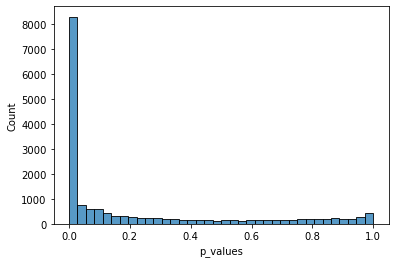

In [26]:
sns.histplot(all_dfr2['p_values'])

In [29]:
all_dfr2[all_dfr2['p_values'] < 5e-8]

,chrom_pos,rsquared_values,p_values,slopes,model,sc,heritability,freq,pi,rep
102,3387729,0.762718,5.810804e-09,-0.035270,delta_p,-1.027103,mediumh,highfreq,onehpoly,4
104,12075487,0.769849,4.012261e-09,-0.061780,delta_p,-2.785579,mediumh,highfreq,onehpoly,4
108,17789038,0.875361,2.408344e-12,0.083580,delta_p,2.129789,mediumh,highfreq,onehpoly,4
114,23908461,0.827979,1.179942e-10,0.086436,delta_p,1.885116,mediumh,highfreq,onehpoly,4
117,26862558,0.837793,5.799606e-11,-0.052904,delta_p,-4.763995,mediumh,highfreq,onehpoly,4
...,...,...,...,...,...,...,...,...,...,...
16883,114994901,0.801397,6.716762e-10,-0.401846,delta_p_norm,-3.136648,lowh,mediumfreq,onehpoly,4
16888,9645484,0.945241,1.202397e-16,-0.261032,delta_p,-4.004391,lowh,highfreq,monogen,5
16889,9645484,0.945241,1.202397e-16,-1.071621,delta_p_norm,-4.004391,lowh,highfreq,monogen,5
16891,9645484,0.854473,1.563079e-11,-0.299488,delta_p,-4.004391,mediumh,highfreq,monogen,5


In [211]:
all_dfr2.set_index('chrom_pos')[['slopes' ]].drop_duplicates()

,slopes
chrom_pos,
1135459,-0.004782
2710060,-0.007902
2864723,-0.014866
3387729,-0.035270
9831114,-0.018934
...,...
9645484,-0.220000
9645484,-0.220000
9645484,-0.903171


In [208]:
all_dfr2.shape

(17010, 10)

In [147]:
all_dfr2['heritability'].unique()

array(['mediumh', 'lowh', 'highh'], dtype=object)

In [148]:
pi_order = ['monogen', 'fivepoly' ,'twentypoly', 'onehpoly']

In [149]:
#colors
custom_colors = sns.color_palette("Greens", n_colors=len(all_dfr2['sc']))

# Create a custom color dictionary
custom_color_dict = dict(zip(custom_categories, custom_colors))

KeyError: 'sc'

In [84]:
all_dfr2

,sc,variable,value,heritability,freq,pi,rep
0,-0.0429,rsquared_valuesallele_freq,0.002902,mediumh,highfreq,onehpoly,4
1,-0.0973,rsquared_valuesallele_freq,0.003198,mediumh,highfreq,onehpoly,4
2,0.1062,rsquared_valuesallele_freq,0.000022,mediumh,highfreq,onehpoly,4
3,0.1542,rsquared_valuesallele_freq,0.000348,mediumh,highfreq,onehpoly,4
4,-0.1678,rsquared_valuesallele_freq,0.004052,mediumh,highfreq,onehpoly,4
...,...,...,...,...,...,...,...
17005,1.4850,rsquared_valuesdelta_p,0.000000,mediumh,lowfreq,monogen,4
17006,1.4850,rsquared_valuesdelta_p_norm,0.000000,mediumh,lowfreq,monogen,4
17007,1.4850,rsquared_valuesallele_freq,NaN,highh,lowfreq,monogen,4
17008,1.4850,rsquared_valuesdelta_p,0.000000,highh,lowfreq,monogen,4


In [85]:
delta_p = all_dfr2[all_dfr2['variable'] == 'rsquared_valuesdelta_p']
allele_freq = all_dfr2[all_dfr2['variable'] == 'rsquared_valuesallele_freq']
delta_p_norm = all_dfr2[all_dfr2['variable'] == 'rsquared_valuesdelta_p_norm']

In [86]:
col_order = ['lowfreq', 'mediumfreq', 'highfreq']

In [87]:
her_order = ['highh', 'mediumh', 'lowh']

In [88]:
hue=all_dfr2[["heritability", 'variable']].apply(tuple, axis=1)

In [89]:
all_dfr2["heritability"].unique()

array(['mediumh', 'lowh', 'highh'], dtype=object)

In [90]:
#colors
custom_categories = her_order
custom_colors = sns.color_palette("Blues", n_colors=len(custom_categories))

# Create a custom color dictionary
custom_color_dict = dict(zip(custom_categories, custom_colors))

In [104]:
highh['variable'].unique()

array(['rsquared_valuesallele_freq', 'rsquared_valuesdelta_p',
       'rsquared_valuesdelta_p_norm'], dtype=object)

In [105]:
#colors
custom_categories = ['rsquared_valuesallele_freq', 'rsquared_valuesdelta_p',
       'rsquared_valuesdelta_p_norm']
custom_colors = sns.color_palette("Blues", n_colors=len(custom_categories))

# Create a custom color dictionary
custom_color_dictblues = dict(zip(custom_categories, custom_colors))

In [106]:
highh = all_dfr2[all_dfr2['heritability'] == 'highh']

In [107]:
highh = highh.dropna()

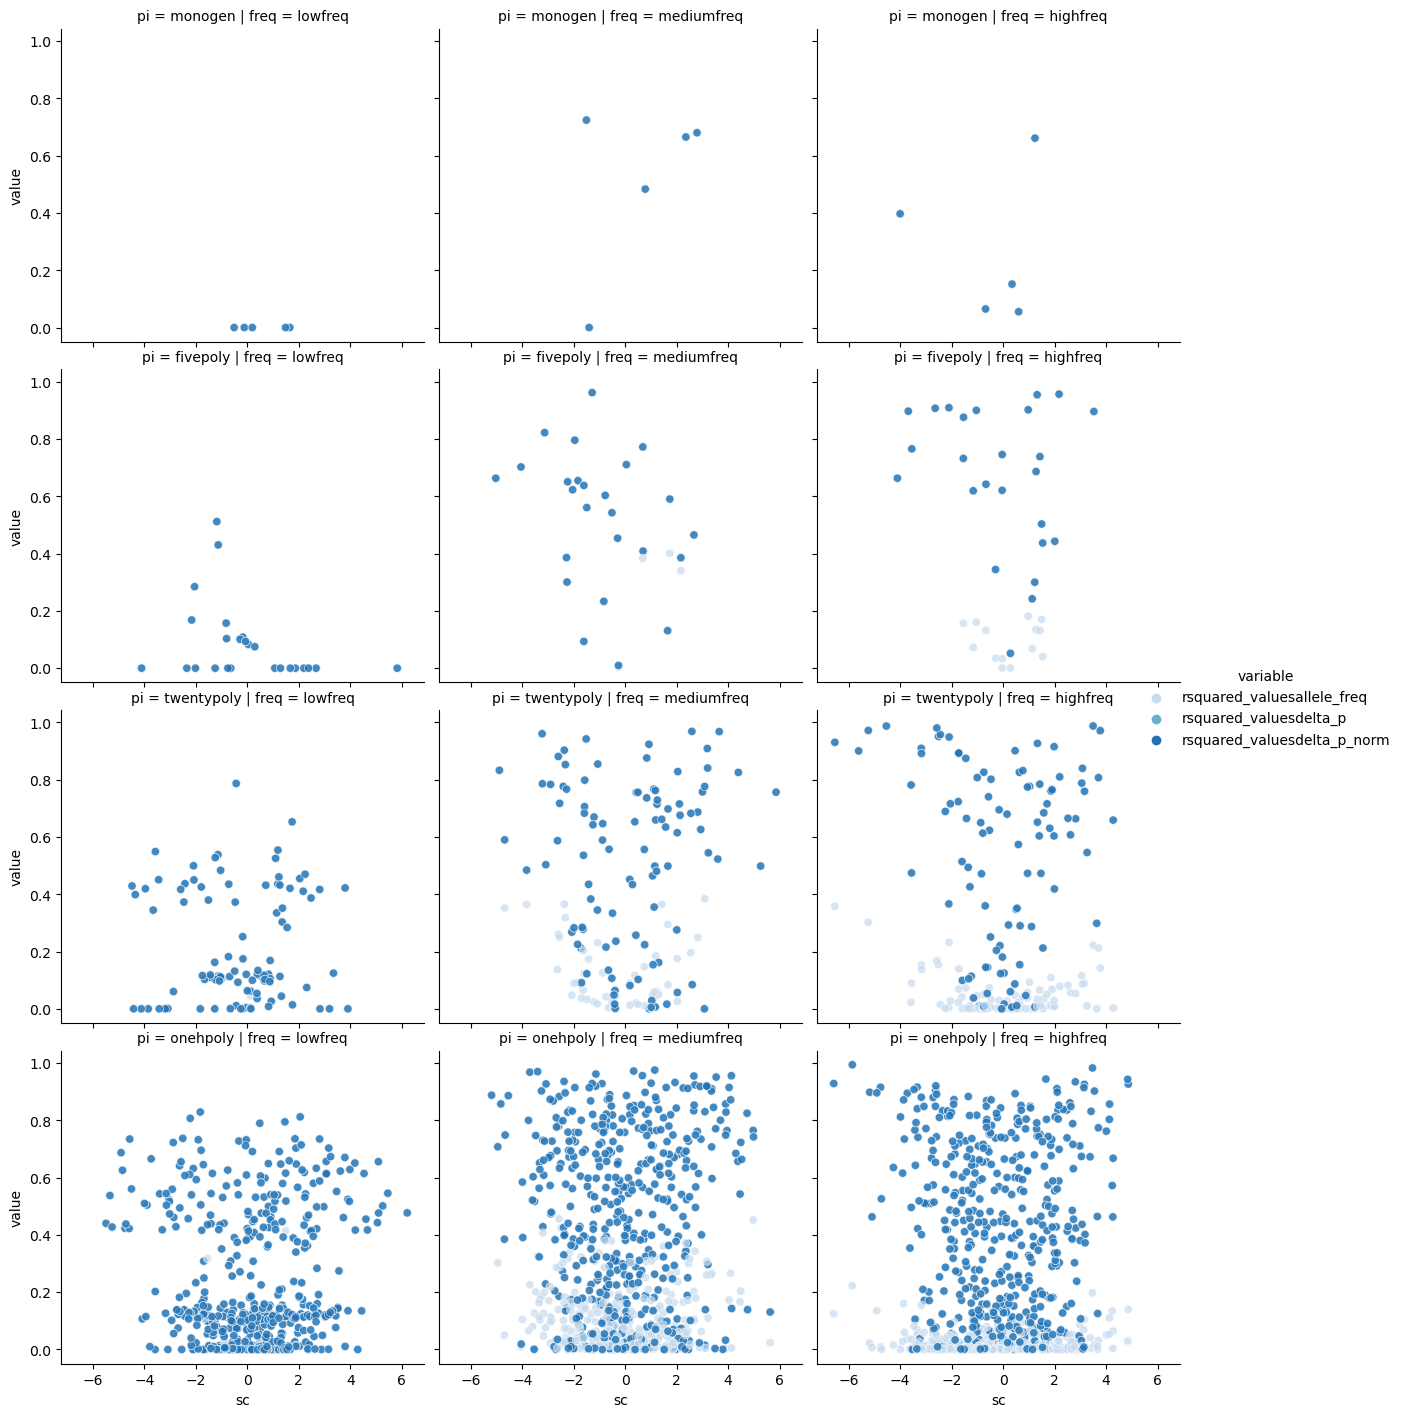

In [109]:
g = sns.relplot(data=highh, x="sc", y="value", hue='variable', col="freq", row="pi",
                #hue_order = her_order,
                palette=custom_color_dictblues,
                row_order = pi_order,alpha=0.7,
                col_order = col_order
           )
g.fig.set_figheight(14)
g.fig.set_figwidth(14)
plt.show()

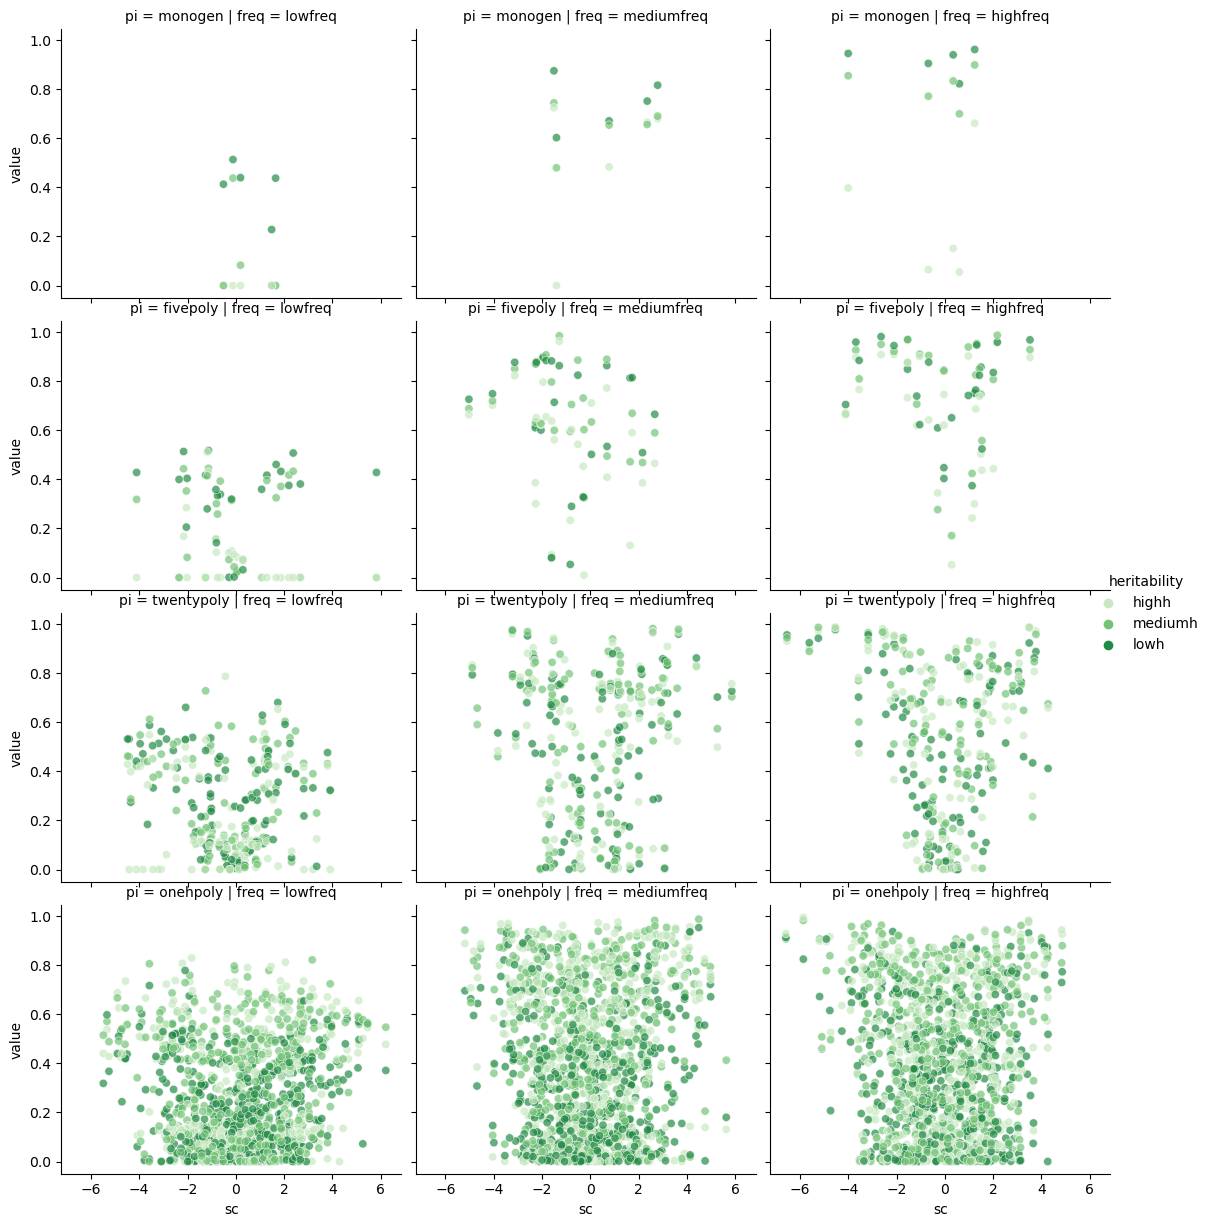

In [91]:
g = sns.relplot(data=delta_p_norm, x="sc", y="value", hue='heritability', col="freq", row="pi",
                hue_order = her_order,
                palette=custom_color_dict,
                row_order = pi_order,alpha=0.7,
                col_order = col_order
           )
g.fig.set_figheight(12)
g.fig.set_figwidth(12)
plt.show()

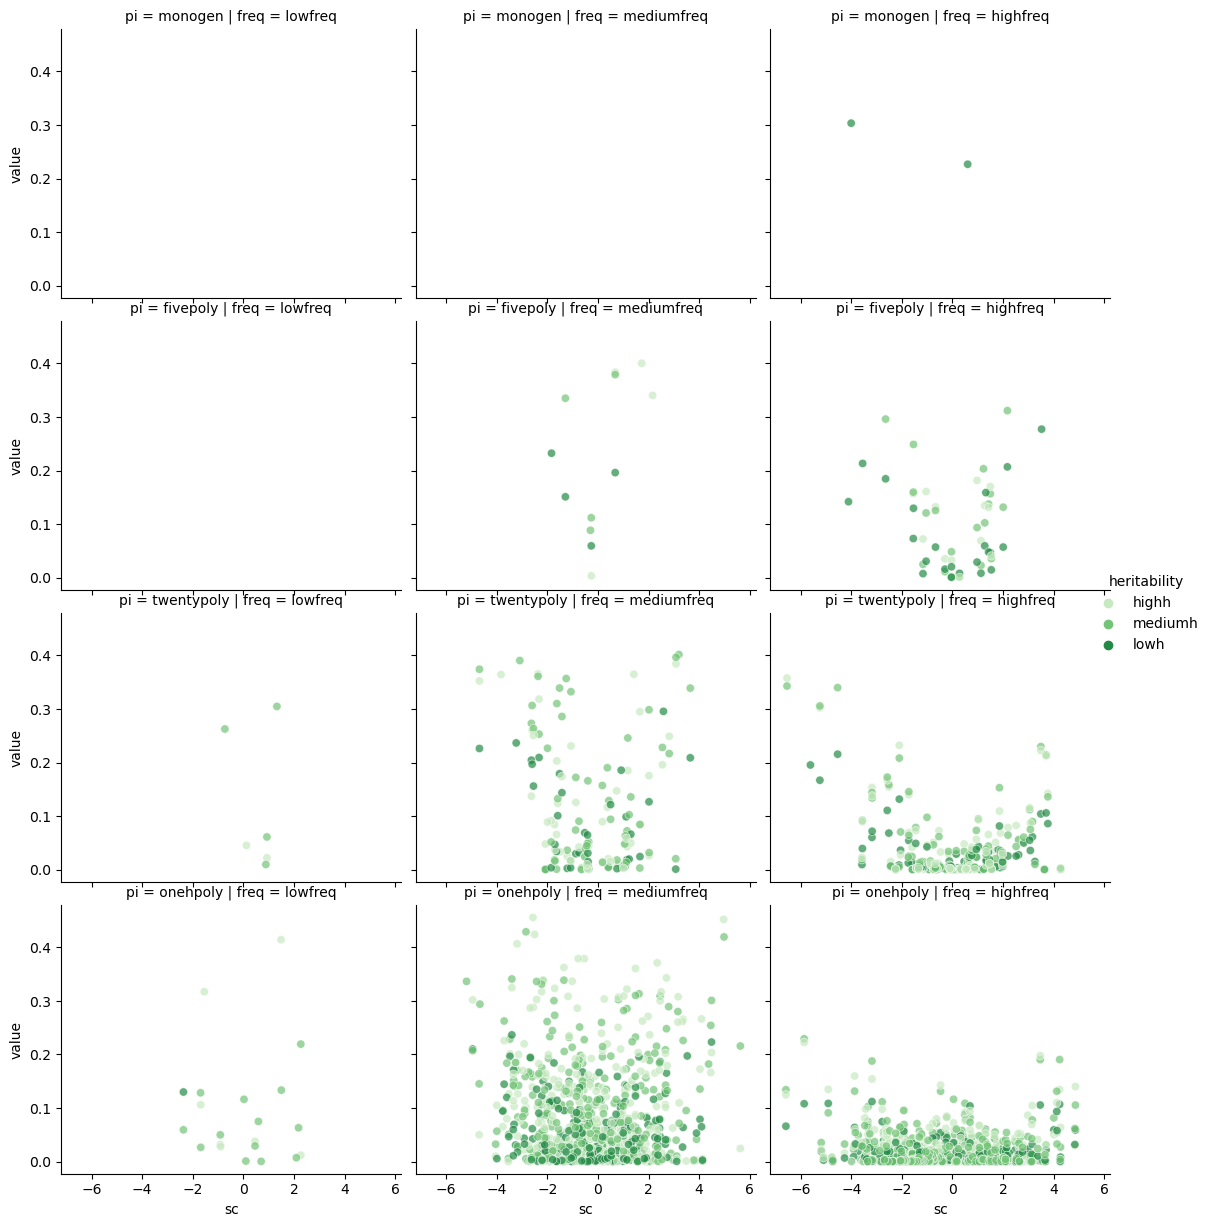

In [93]:
g = sns.relplot(data=allele_freq, x="sc", y="value", hue='heritability', col="freq", row="pi",
                hue_order = her_order,
                palette=custom_color_dict,
                row_order = pi_order,alpha=0.7,
                col_order = col_order
           )
g.fig.set_figheight(12)
g.fig.set_figwidth(12)
plt.show()

In [75]:
(allele_freq.reset_index(drop=True) == delta_p.reset_index(drop=True)).sum()

sc              5670
variable           0
value           2941
heritability    5670
freq            5670
pi              5670
rep             5670
dtype: int64

In [71]:
delta_p

,sc,variable,value,heritability,freq,pi,rep
100,-0.0429,rsquared_valuesdelta_p,0.002902,mediumh,highfreq,onehpoly,4
101,-0.0973,rsquared_valuesdelta_p,0.003198,mediumh,highfreq,onehpoly,4
102,0.1062,rsquared_valuesdelta_p,0.000022,mediumh,highfreq,onehpoly,4
103,0.1542,rsquared_valuesdelta_p,0.000348,mediumh,highfreq,onehpoly,4
104,-0.1678,rsquared_valuesdelta_p,0.004052,mediumh,highfreq,onehpoly,4
...,...,...,...,...,...,...,...
16996,-4.0044,rsquared_valuesdelta_p,NaN,mediumh,highfreq,monogen,5
16999,-4.0044,rsquared_valuesdelta_p,NaN,highh,highfreq,monogen,5
17002,1.4850,rsquared_valuesdelta_p,NaN,lowh,lowfreq,monogen,4
17005,1.4850,rsquared_valuesdelta_p,NaN,mediumh,lowfreq,monogen,4
